# SIMEX notebook for diffraction from spherical objects.

In this notebook, we study diffraction of coherent radiation from spherical objects. We investigate the dependency of the diffraction pattern on the spheres' diameter and, in the case of multiple spheres, their distance.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters
from SimEx.Analysis.XFELPhotonAnalysis import XFELPhotonAnalysis

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy
import copy

initializing ocelot...


### Setup the initial wavefront
We first create a wavefront at $z=100$ m downstream from the source. The intensity distribution in $x$, $y$, and $t$ is assumed to be Gaussian. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter class, the `GaussWavefrontParameters`.

We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [3]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=30,
                                                z = 100*meter
                                                )

Now, we use the just created `wavefront_parameters` to initialize the Photon Source.

In [4]:
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it:

In [5]:
photon_source.backengine()

#### Save wavefront data for later re-use

In [6]:
photon_source.saveH5()

### Creata analysis object and generate some plots

In [7]:
analysis = XFELPhotonAnalysis('initial_wavefront.h5')


 Start initialization.

 Loading wavefront from initial_wavefront.h5.
 ... done.

 Getting intensities.
 ... done.
 Data dimensions =  (400, 400, 30)

 Masking NANs.
 ... done.


#### Intensity map


 Plotting intensity map.
R-space


<Figure size 432x288 with 0 Axes>

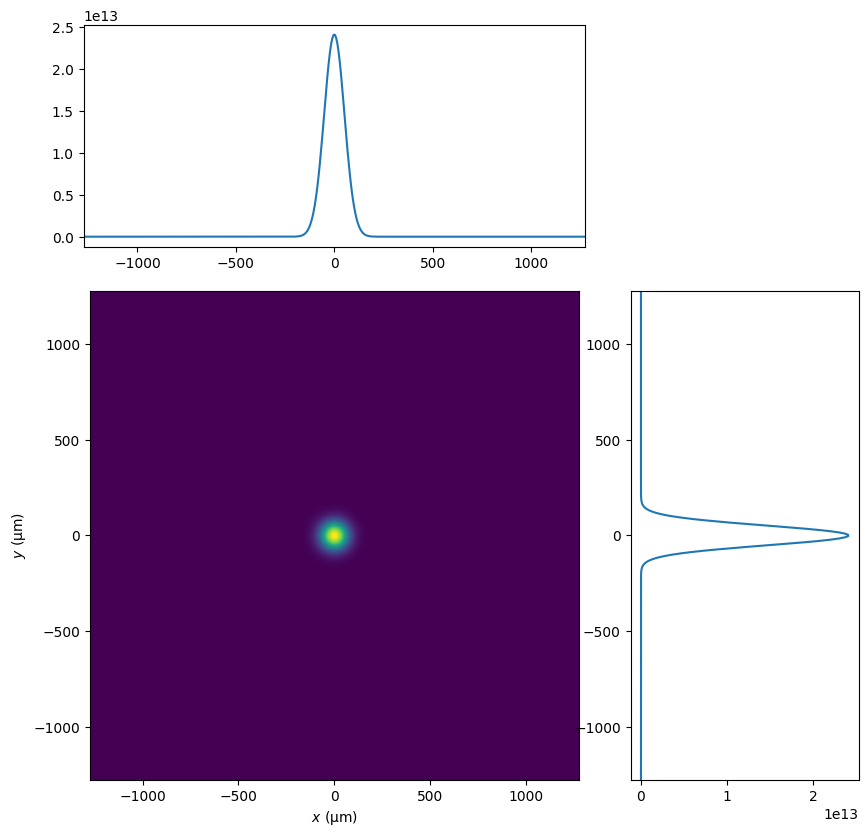

In [8]:
analysis.plotIntensityMap()

#### On-axis power density as function of time


 Plotting on-axis power density.


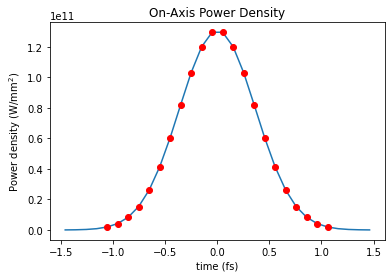

In [9]:
analysis.plotOnAxisPowerDensity()

## Plot intensity distribution in q-space


 Plotting intensity map.

 Switching to reciprocal space.
 ... done.
Q-space


<Figure size 432x288 with 0 Axes>

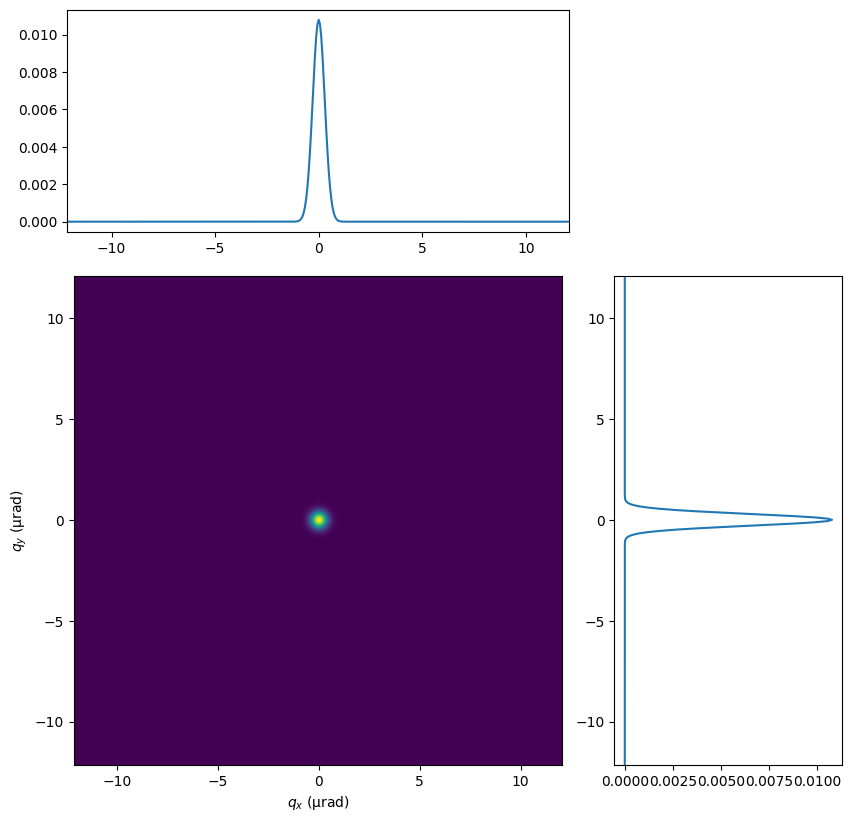

In [10]:
analysis.plotIntensityMap(qspace=True)

Plot the power as a function of time integrated over the transverse dimensions


 Plotting total power.
Pulse energy 2e-06 J


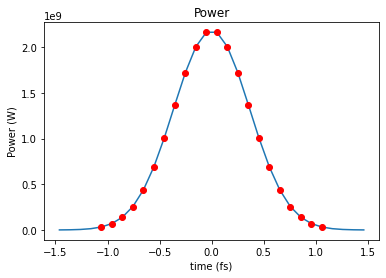

In [11]:
analysis.plotTotalPower()

Plot the power spectrum


 Plotting total power.

 Switching to frequency domain.


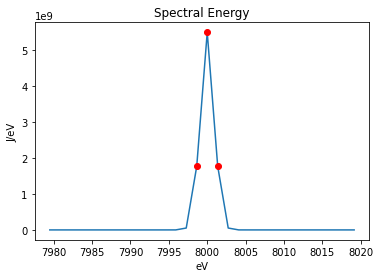

In [12]:
analysis.plotTotalPower(spectrum=True)

In [13]:
import wpg
from wpg import wpg_uti_wf as wpg_utils

In [14]:
wavefront = copy.deepcopy(photon_source.data)

Check the sampling quality

In [15]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
|Vertical  |1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


## Setup the beamline
Our experiment consists of
* The photon source at the origin
* 100 m of free space (already taken into account in the wavefront construction).
* The diffraction object (the edge)
* Another distance of free space
* The detector (screen)

In [16]:
from wpg import Beamline, optical_elements, srwlib
from wpg.useful_code.wfrutils import propagate_wavefront

In [17]:
beamline = Beamline()

## Setting up the sample
To define the sample, we make use of the `Aperture` class in `wpg.optical_elements`. 

In [18]:
optical_elements.Aperture?

Signature: optical_elements.Aperture(shape, ap_or_ob, Dx, Dy=1e+23, x=0, y=0)
Docstring:
Defining an aperture/obstacle propagator: A wrapper to a SRWL function SRWLOptA()

:param shape:    'r' for rectangular, 'c' for circular
:param ap_or_ob:  'a' for aperture, 'o' for obstacle
:param Dx, Dy:   transverse dimensions [m]; in case of circular aperture, only Dx is used for diameter
:param x, y:     transverse coordinates of center [m]
:return: opAp  - aperture propagator, ``struct SRWLOptA``
File:      ~/Projects/dot.conda/envs/simex/lib/python3.7/wpg/optical_elements.py
Type:      function


We set up a circular (`shape='c'`) obstacle (`ap_or_ob = 'ob'`) of radius $100$ nm in both and place it at the beam center
$x_\text{center} = y_\text{center} = 0$ (`x=0`, `y=0`).

In [19]:
sample = optical_elements.Aperture(
    shape='c',
    ap_or_ob='o',
    Dx=1.0e-7,
    Dy=1.0e-7,
    x=0.0,
    y=0.0,
)

In [23]:
sample_pp = optical_elements.Use_PP(semi_analytical_treatment=0)

In [24]:
beamline.append(sample, sample_pp)

In [25]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
propagate_wavefront(wavefront,beamline)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 1e-07
	Dy = 1e-07
	ap_or_ob = o
	shape = c
	x = 0.0
	y = 0.0
	

R-space
nx   400  range_x [-1.3e+00, 1.3e+00] mm
ny   400  range_y [-1.3e+00, 1.3e+00] mm
*****propagating wavefront (with resizing)...
done


R-space
(400,) (400,)
FWHM in x = 1.147e-04 m.
FWHM in y = 1.147e-04 m.


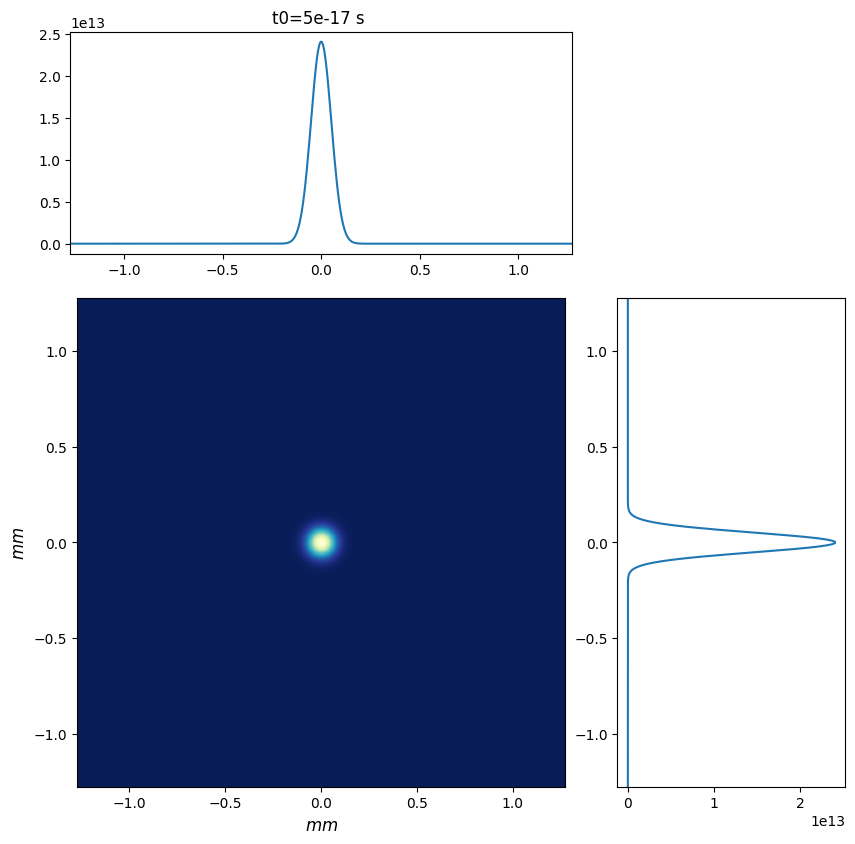

In [26]:
wpg_utils.plot_intensity_map(wavefront)

Immediately after the edge, the intensity distribution is characterized by a sharply distinguished shadow are that goes right through the center of the intensity distribution. In the y-direction, the distribution is identical to the situation before the wire.

In [25]:
# Propagate for another 100 m

In [25]:
edge_to_screen = optical_elements.Drift(_L=100, _treat=1)

In [26]:
edge_to_screen_pp = optical_elements.Use_PP(semi_analytical_treatment=1)

In [30]:
beamline.append(edge_to_screen, edge_to_screen_pp)

In [31]:
# Reset the wavefront.
wavefront = copy.deepcopy(photon_source.data)

In [32]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
propagate_wavefront(wavefront, beamline)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 1.0
	Dy = 1.0
	ap_or_ob = o
	shape = r
	x = -0.5
	y = 0.0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 100
	treat = 1
	

R-space
nx   400  range_x [-1.3e+00, 1.3e+00] mm
ny   400  range_y [-1.3e+00, 1.3e+00] mm
*****propagating wavefront (with resizing)...
done


R-space
(400,) (400,)
FWHM in x = 1.083e-04 m.
FWHM in y = 1.656e-04 m.


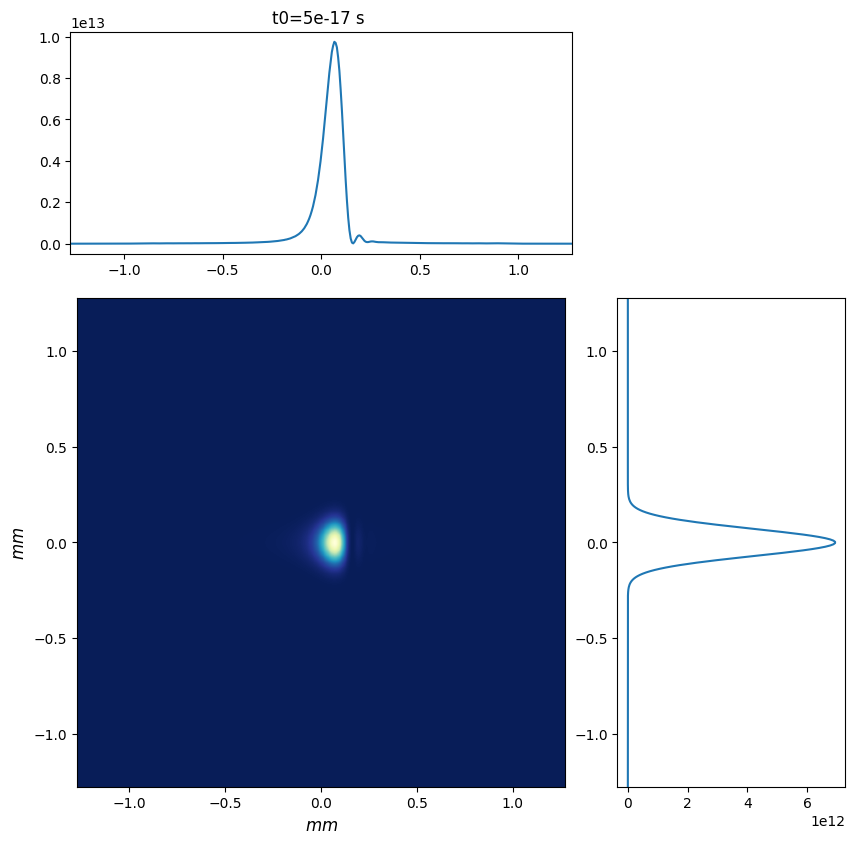

In [33]:
wpg_utils.plot_intensity_map(wavefront)

We observe that some photons have been diffracted into the shadow region of the edge.

**Tasks**
1. Revisit the analytical solution of the diffraction pattern of a semi-infinite edge.
1. Make plot that shows the simulated pattern and the analytical solution in the x and y projection in the same graph.